<a href="https://colab.research.google.com/github/qmaruf/fastai/blob/master/fast_ai_largest_object_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print (sys.version)

import sys
print (sys.version)
! pip3 install fastai==0.7.0
! pip3 install torchtext==0.2.3

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

!mkdir data
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P data/
!wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip -P data/
!tar -xf data/VOCtrainval_06-Nov-2007.tar -C data/
!unzip data/PASCAL_VOC.zip -d data/
!rm -rf data/PASCAL_VOC.zip data/VOCtrainval_06-Nov-2007.tar

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
mkdir: cannot create directory ‘data’: File exists
URL transformed to HTTPS due to an HSTS policy
--2019-03-16 13:14:47--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘data/VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  68.1MB/s    in 6.6s    

2019-03-16 13:14:54 (66.7 MB/s) - ‘data/VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2019-03-16 13:14:56--  https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 2607:f8b0:4001:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108

In [2]:
PATH = Path('data/PASCAL_VOC/')
list(PATH.iterdir())

[PosixPath('data/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('data/PASCAL_VOC/tmp'),
 PosixPath('data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('data/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('data/PASCAL_VOC/pascal_val2007.json')]

In [0]:
train_json = json.load((PATH/'pascal_train2007.json').open())

In [10]:
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [0]:
IMAGES, TYPE, ANNOTATIONS, CATEGORIES = ['images', 'type', 'annotations', 'categories']

In [15]:
images_dir = Path('./data/VOCdevkit/VOC2007/JPEGImages/')
next(images_dir.iterdir())

PosixPath('data/VOCdevkit/VOC2007/JPEGImages/000951.jpg')

In [0]:
# dictionary to keep image_id vs bbox and and corresponding category
annotation_dict = collections.defaultdict(lambda:[])
for item in train_json[ANNOTATIONS]:
#     print (item['image_id'])
#     print (item['bbox'])
#     print (item['category_id'])
    annotation_dict[item['image_id']].append((item['category_id'], item['bbox']))
#     break

In [24]:
len(annotation_dict)

2501

In [0]:
# dictionary to keep image id to image path
image_id_to_filename = dict()
for item in train_json[IMAGES]:
    image_id_to_filename[item['id']]= images_dir/item['file_name']

In [0]:
image_id_to_category = dict()
for item in train_json[CATEGORIES]:
    image_id_to_category[item['id']]=item['name']

In [0]:
# image_id_to_filename

In [0]:
def coord_to_hw(bb):
    return np.array([bb[0], bb[1], bb[2]-bb[0]+1, bb[3]-bb[1]+1])

def hw_to_coord(bb):
    return np.array([bb[0], bb[1], bb[0]+bb[2], bb[1]+bb[3]])

def draw_image(image, figsize=None, ax=None):
    if ax is None: 
        fig, ax = plt.subplots()
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_bbox(ax, bbox):
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    
def add_text(ax, bb, txt):
    text = ax.text(bb[0], bb[1], txt, fontsize=14, color='white', weight='bold', backgroundcolor='black') 

(15, [184, 61, 95, 138])
(13, [89, 77, 314, 259])


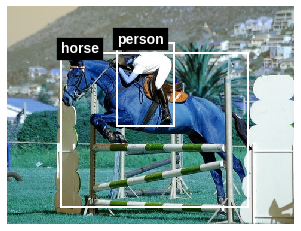

In [88]:
image_id = 17
image = cv2.imread(str(image_id_to_filename[image_id]))
ax = draw_image(image)
for bbox in annotation_dict[image_id]:
    print (bbox)
    draw_bbox(ax, bbox[1])
    add_text(ax, bbox[1], image_id_to_category[bbox[0]])

In [0]:
annotation_dict_large = dict()
for image_id in annotation_dict:
    bboxes = (annotation_dict[image_id])
    lrg_bb = sorted(bboxes, key=lambda x: x[1][2]*x[1][3], reverse=True)[0]
    annotation_dict_large[image_id]=lrg_bb

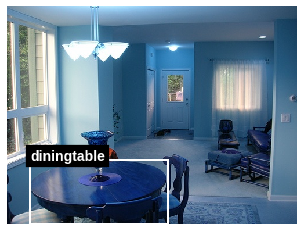

In [96]:
image_id = 235
image = cv2.imread(str(image_id_to_filename[image_id]))
ax = draw_image(image)
draw_bbox(ax, annotation_dict_large[image_id][1])
add_text(ax, annotation_dict_large[image_id][1], image_id_to_category[annotation_dict_large[image_id][0]])

In [0]:
df = pd.DataFrame(
{
    'image_path': [images_dir/image_id_to_filename[id] for id in annotation_dict_large],
    'category': [image_id_to_category[annotation_dict_large[id][0]] for id in annotation_dict_large],
    'bbox': [','.join(list(map(str, hw_to_coord(annotation_dict_large[id][1])))) for id in annotation_dict_large]
})


,bbox,category,image_path
0,"155,96,351,270",car,data/VOCdevkit/VOC2007/JPEGImages/data/VOCdevk...
1,"89,77,403,336",horse,data/VOCdevkit/VOC2007/JPEGImages/data/VOCdevk...
2,"2,1,243,462",person,data/VOCdevkit/VOC2007/JPEGImages/data/VOCdevk...
3,"89,124,337,212",car,data/VOCdevkit/VOC2007/JPEGImages/data/VOCdevk...
4,"103,77,375,183",aeroplane,data/VOCdevkit/VOC2007/JPEGImages/data/VOCdevk...
5,"8,106,499,263",aeroplane,data/VOCdevkit/VOC2007/JPEGImages/data/VOCdevk...
6,"115,166,360,400",train,data/VOCdevkit/VOC2007/JPEGImages/data/VOCdevk...
7,"217,97,465,318",person,data/VOCdevkit/VOC2007/JPEGImages/data/VOCdevk...
8,"26,78,319,344",dog,data/VOCdevkit/VOC2007/JPEGImages/data/VOCdevk...
9,"262,31,500,295",train,data/VOCdevkit/VOC2007/JPEGImages/data/VOCdevk...
